In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_df = pd.read_csv("./data/train.csv", index_col="id")

train_df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [3]:
train_df.describe().columns

Index(['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
       'Friends_circle_size', 'Post_frequency'],
      dtype='object')

In [20]:
# Check if there are any missing values
missing_values = train_df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])
print("Total rows:", len(train_df))

Missing values in each column:
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
dtype: int64
Total rows: 18524


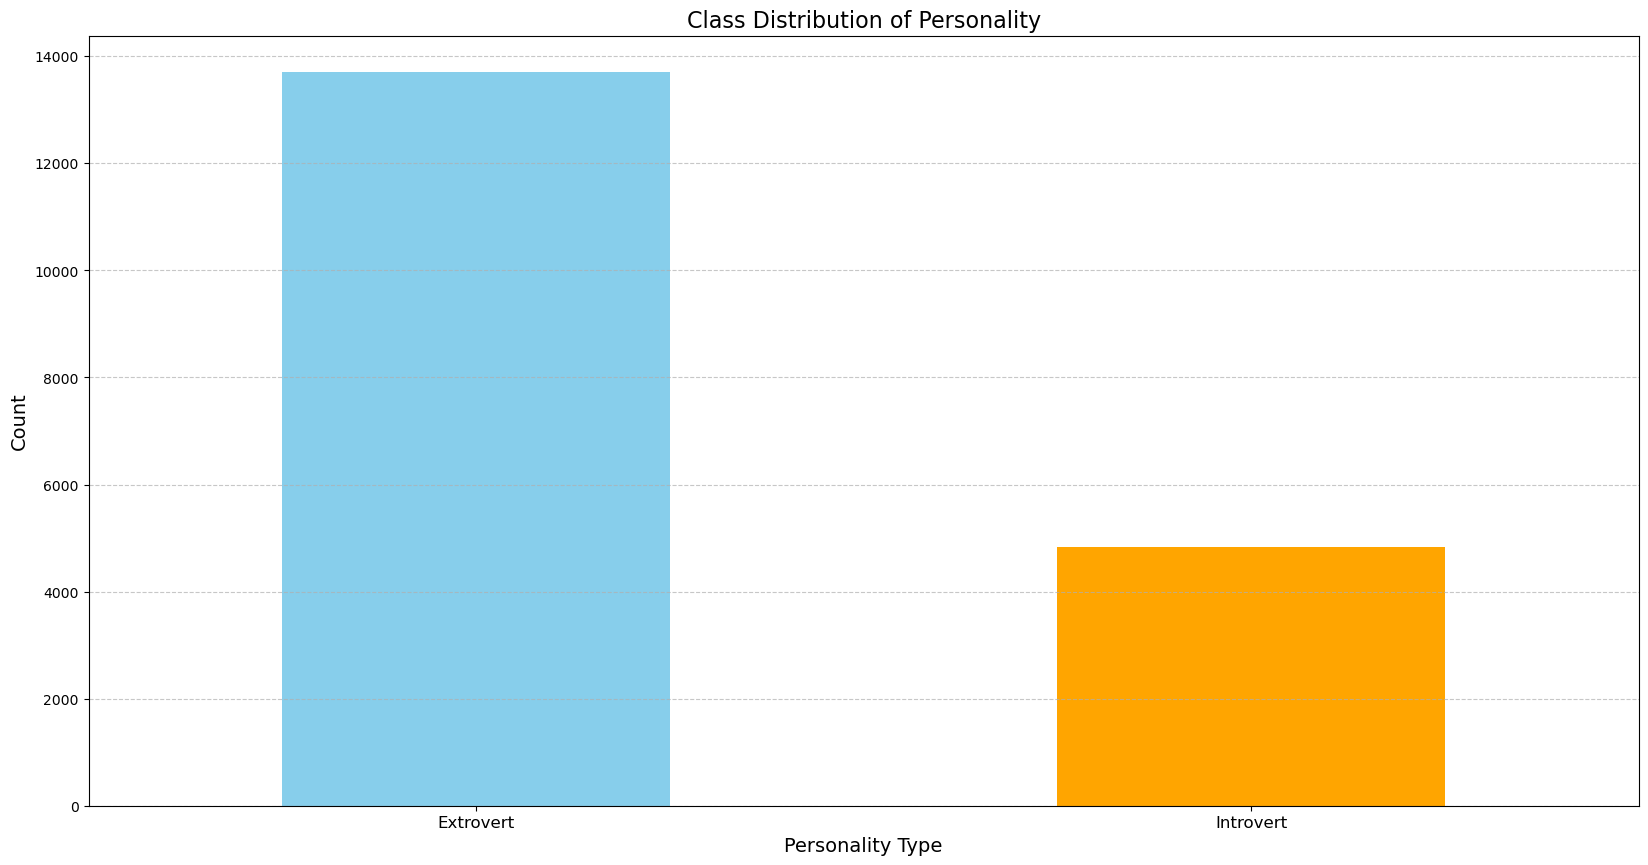

In [23]:
# Visualize the class distribution with improved chart
plt.figure(figsize=(20, 10))
train_df["Personality"].value_counts().plot(kind="bar", color=["skyblue", "orange"])
plt.title("Class Distribution of Personality", fontsize=16)
plt.xlabel("Personality Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

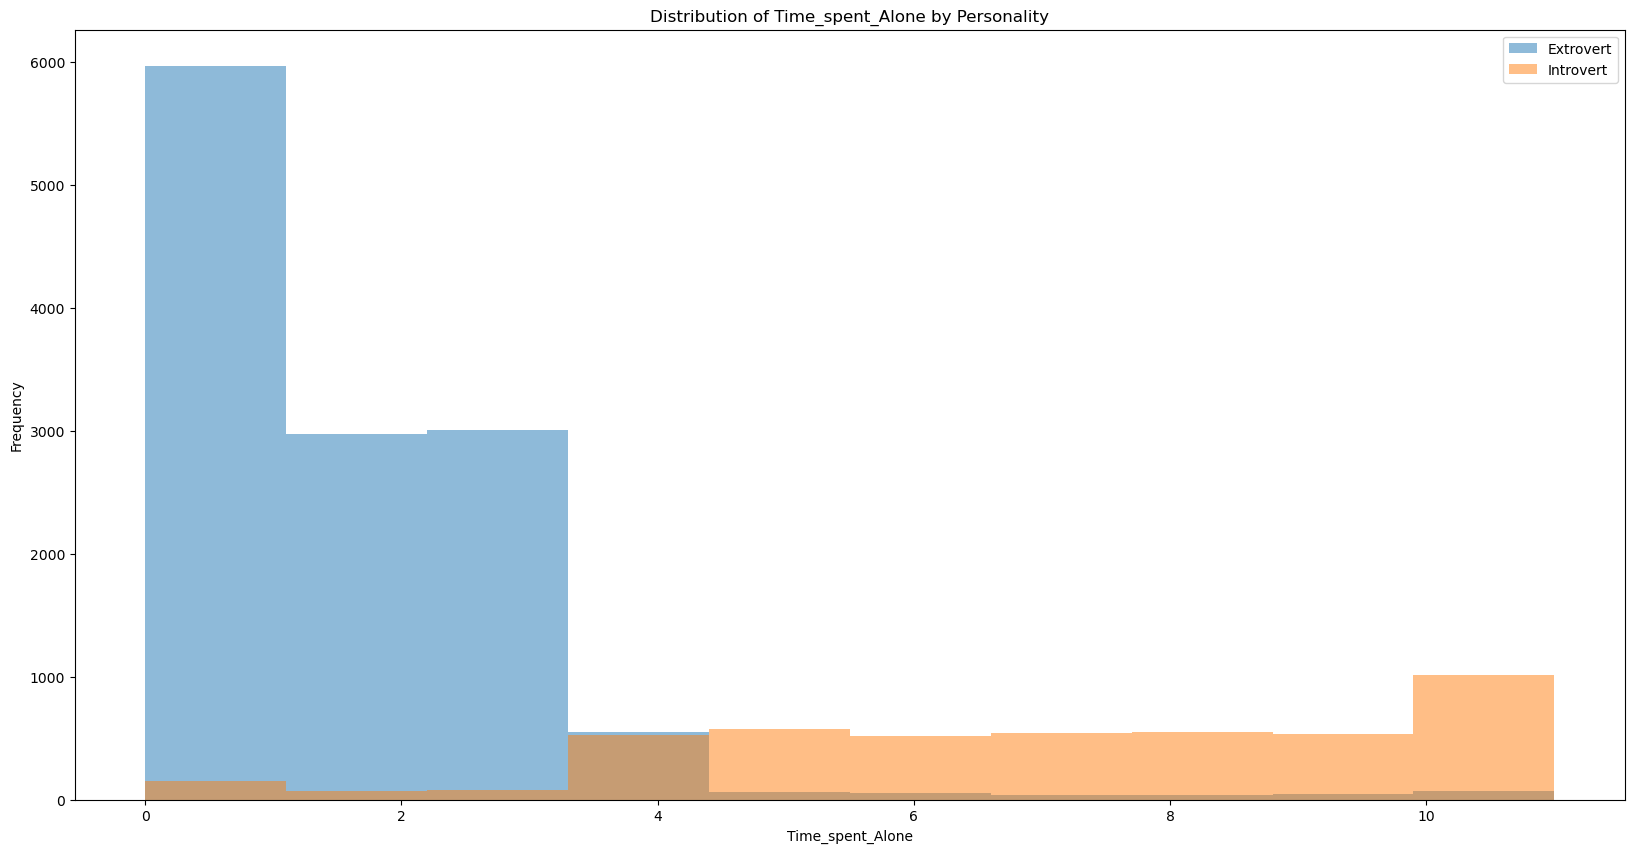

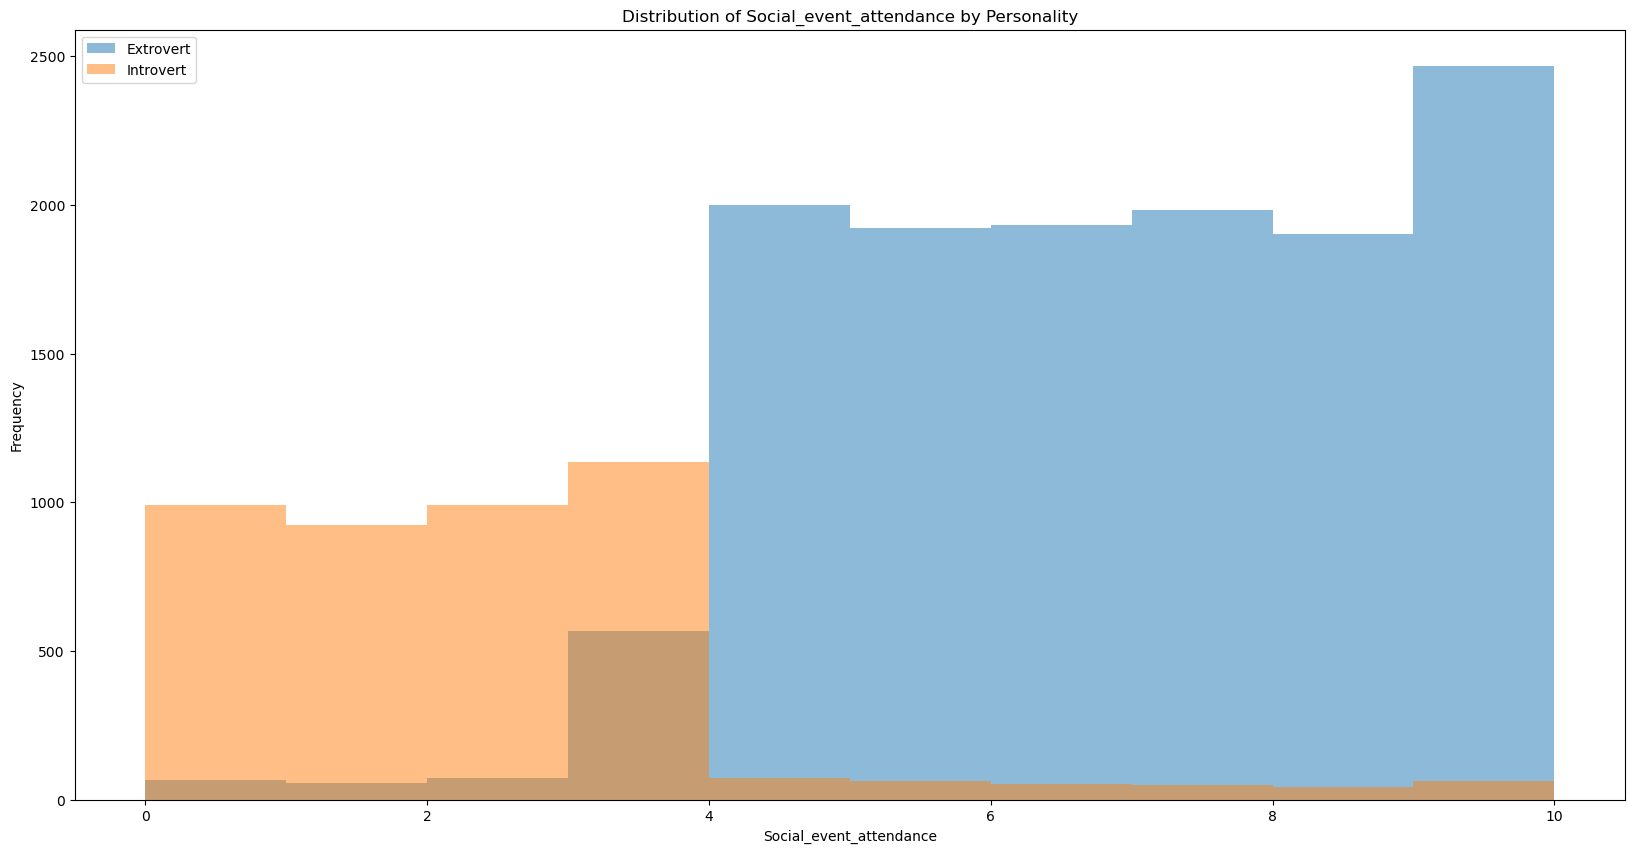

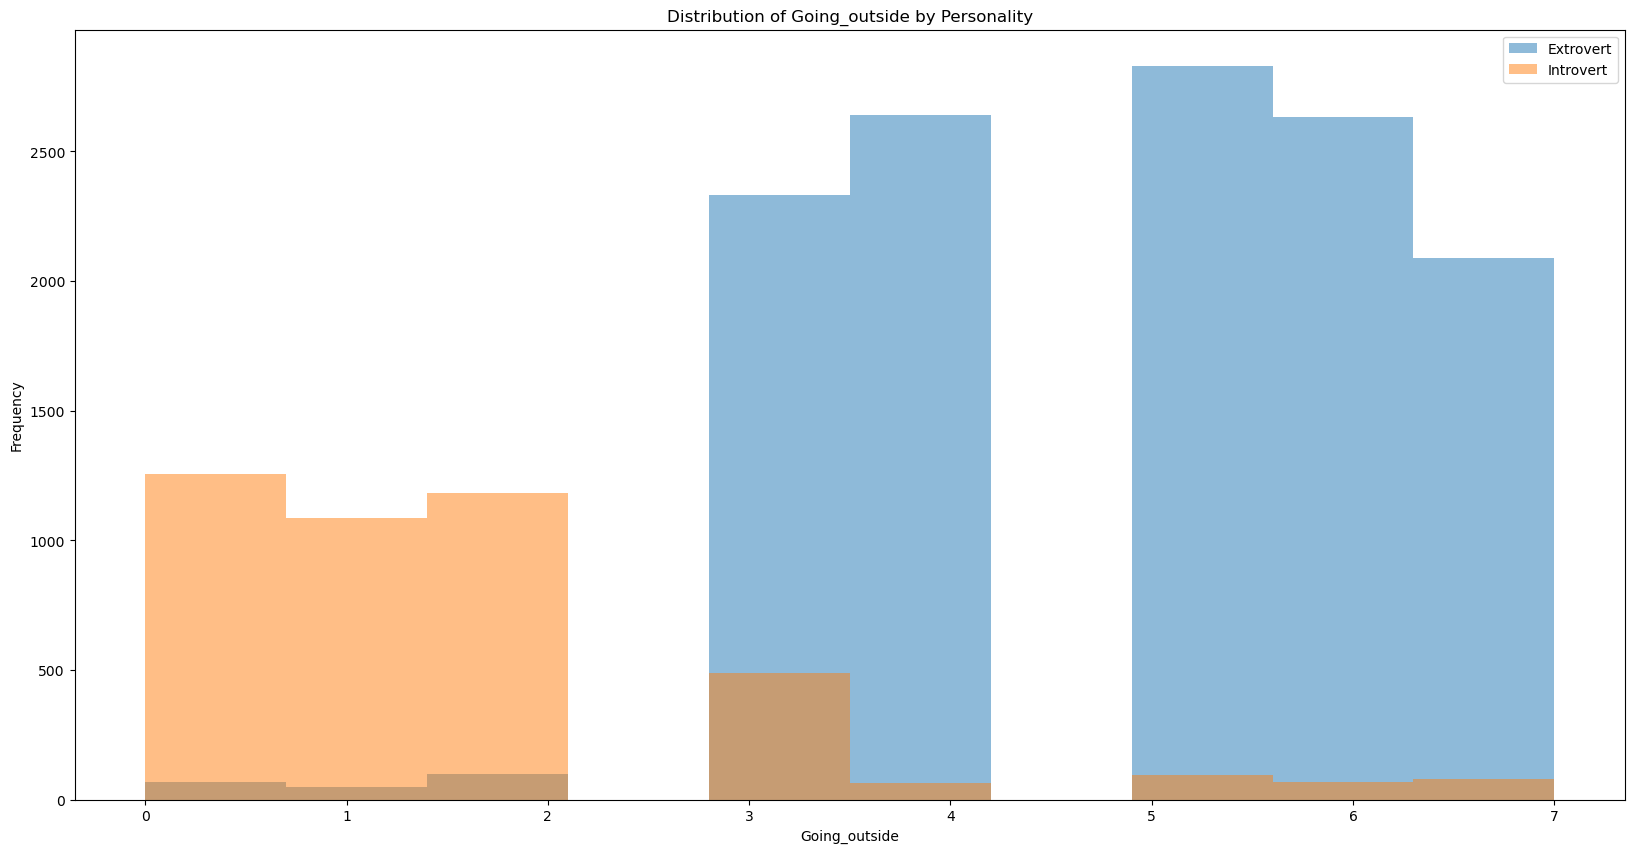

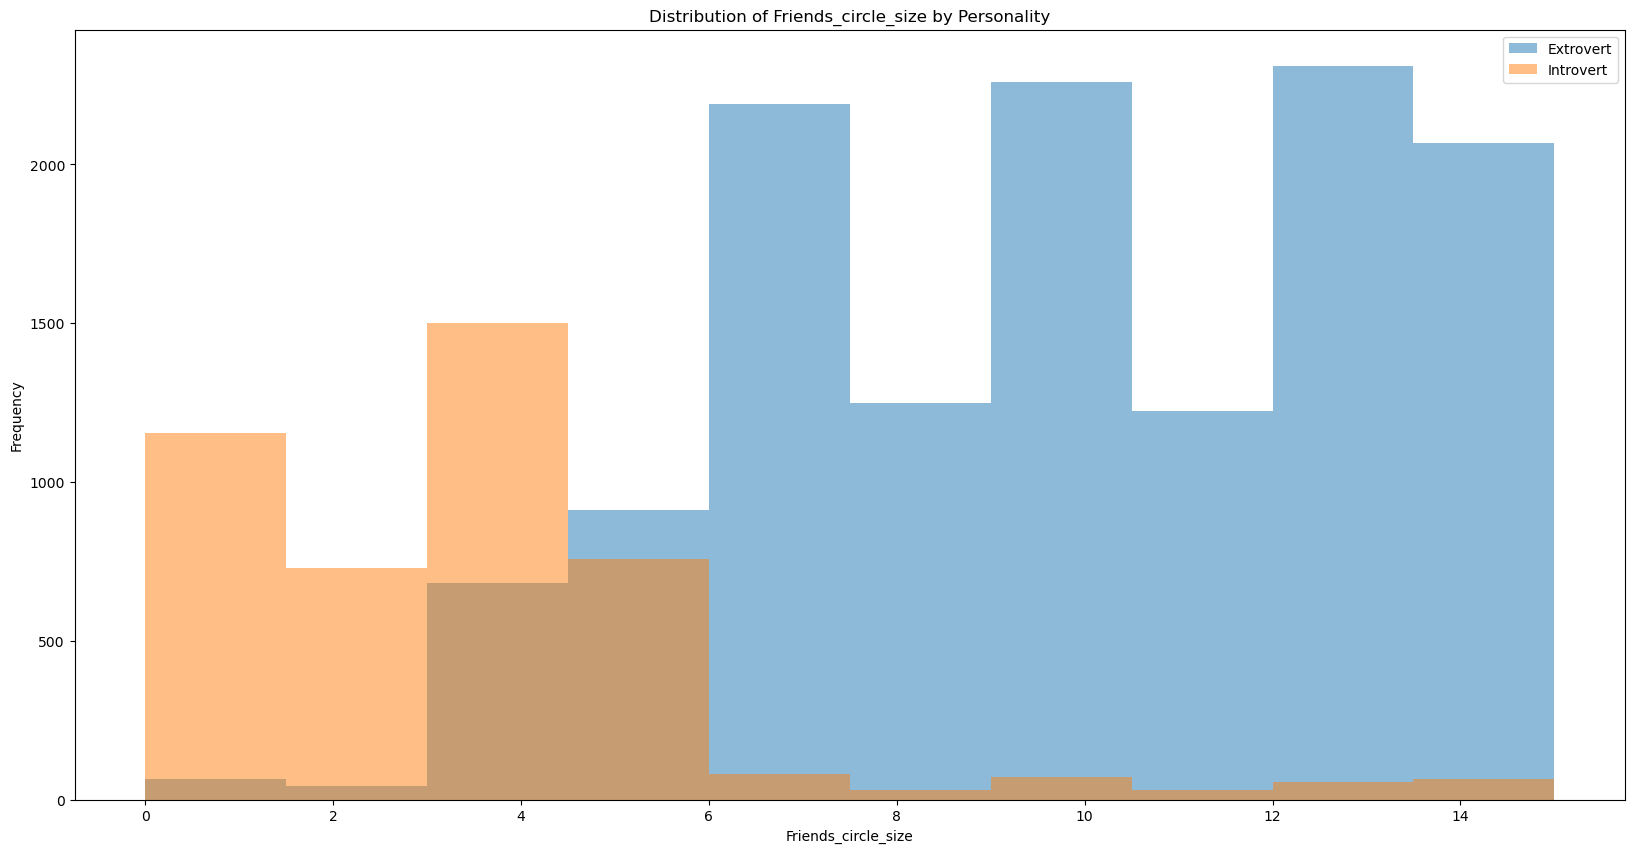

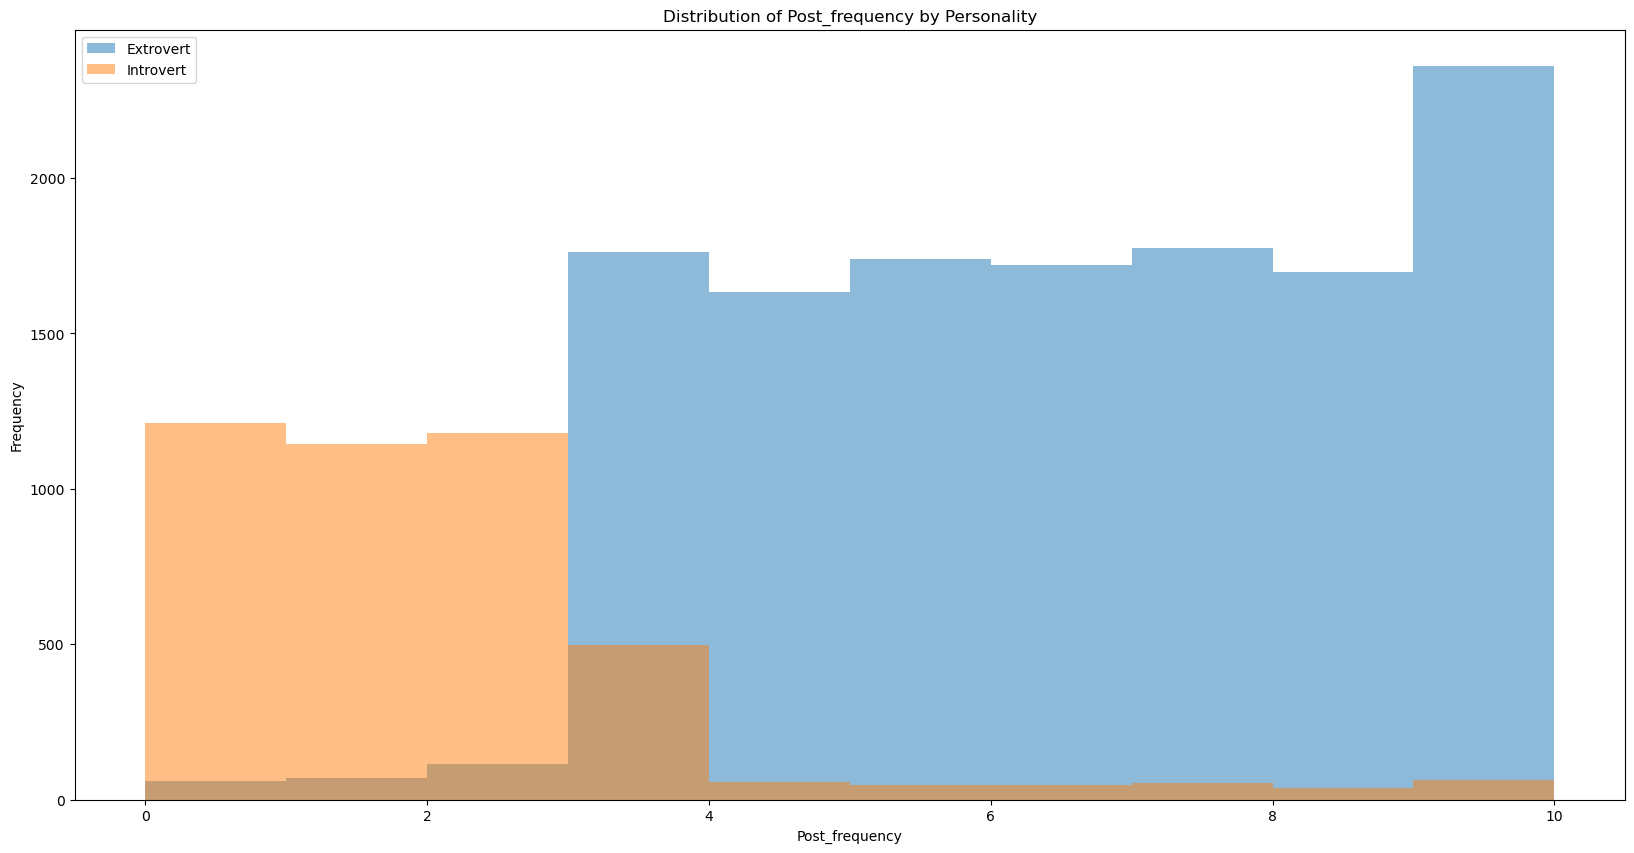

In [4]:
for col in train_df.describe().columns:
    plt.figure(figsize=(20, 10))
    train_df.groupby("Personality")[col].plot(kind="hist", alpha=0.5, legend=True)
    plt.title(f"Distribution of {col} by Personality")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [5]:
X = train_df.drop(columns=["Personality"])
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = X[col].astype("category")

y = train_df["Personality"].astype("category")


In [6]:
y

id
0        Extrovert
1        Extrovert
2        Introvert
3        Extrovert
4        Extrovert
           ...    
18519    Extrovert
18520    Extrovert
18521    Introvert
18522    Introvert
18523    Extrovert
Name: Personality, Length: 18524, dtype: category
Categories (2, object): ['Extrovert', 'Introvert']

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [12]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Baseline

In [9]:
import xgboost as xgb

In [13]:
# Create binary classification model with XGBoost
d_train = xgb.DMatrix(X_train, label=y_train_encoded, enable_categorical=True)
d_val = xgb.DMatrix(X_val, label=y_val_encoded, enable_categorical=True)

model = xgb.train(
    params={
        "objective": "multi:softmax",
        "num_class": len(y.unique()),
        "eval_metric": "mlogloss",
        "max_depth": 6,
        "eta": 0.1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42,
        "verbosity": 1,
    },
    dtrain=d_train,
    num_boost_round=100,
    evals=[(d_train, "train"), (d_val, "val")],
    early_stopping_rounds=10,
)

[0]	train-mlogloss:0.60934	val-mlogloss:0.60912
[1]	train-mlogloss:0.54073	val-mlogloss:0.54023


[2]	train-mlogloss:0.48340	val-mlogloss:0.48273
[3]	train-mlogloss:0.43545	val-mlogloss:0.43453
[4]	train-mlogloss:0.39467	val-mlogloss:0.39349
[5]	train-mlogloss:0.35951	val-mlogloss:0.35816
[6]	train-mlogloss:0.32938	val-mlogloss:0.32800
[7]	train-mlogloss:0.30314	val-mlogloss:0.30174
[8]	train-mlogloss:0.28040	val-mlogloss:0.27907
[9]	train-mlogloss:0.26055	val-mlogloss:0.25925
[10]	train-mlogloss:0.24330	val-mlogloss:0.24195
[11]	train-mlogloss:0.22820	val-mlogloss:0.22686
[12]	train-mlogloss:0.21494	val-mlogloss:0.21361
[13]	train-mlogloss:0.20340	val-mlogloss:0.20208
[14]	train-mlogloss:0.19324	val-mlogloss:0.19191
[15]	train-mlogloss:0.18412	val-mlogloss:0.18290
[16]	train-mlogloss:0.17604	val-mlogloss:0.17516
[17]	train-mlogloss:0.16900	val-mlogloss:0.16825
[18]	train-mlogloss:0.16286	val-mlogloss:0.16233
[19]	train-mlogloss:0.15746	val-mlogloss:0.15708
[20]	train-mlogloss:0.15279	val-mlogloss:0.15253
[21]	train-mlogloss:0.14857	val-mlogloss:0.14854
[22]	train-mlogloss:0.14485	

In [14]:
predictions = model.predict(d_val)

In [16]:
from sklearn.metrics import classification_report

In [18]:
print(classification_report(y_val_encoded, predictions, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



In [25]:
test_df = pd.read_csv("./data/test.csv", index_col="id")
X_test = test_df.copy()
for col in X_test.columns:
    if X_test[col].dtype == "object":
        X_test[col] = X_test[col].astype("category")
d_test = xgb.DMatrix(X_test, enable_categorical=True)
test_predictions = model.predict(d_test)

In [27]:
test_df["Personality"] = label_encoder.inverse_transform(test_predictions.astype(int))

test_df

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
18524,3.0,No,7.0,4.0,No,6.0,NaN,Extrovert
18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0,Introvert
18526,3.0,No,5.0,6.0,No,15.0,9.0,Extrovert
18527,3.0,No,4.0,4.0,No,5.0,6.0,Extrovert
18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0,Introvert
...,...,...,...,...,...,...,...,...
24694,3.0,No,5.0,5.0,No,9.0,6.0,Extrovert
24695,8.0,Yes,2.0,1.0,Yes,0.0,0.0,Introvert
24696,2.0,No,4.0,3.0,No,9.0,7.0,Extrovert


In [28]:
test_df[["Personality"]].to_csv("./data/submission.csv", index=True, header=True)

In [29]:
from datetime import datetime

now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

! kaggle competitions submit -c playground-series-s5e7 -f ./data/submission.csv -m "Submission at {now}"

100%|██████████████████████████████████████| 96.5k/96.5k [00:01<00:00, 56.4kB/s]
Successfully submitted to Predict the Introverts from the Extroverts

In [30]:
# Score: 0.974898